# Densely Connected Convolutional Networks (DenseNets)


In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

#### Main takeways of the DenseNet paper (https://github.com/liuzhuang13/DenseNet)

_These are my notes, kindly ignore_

1. Concatenation of features (filters)

   - In contrast to ResNets, DenseNets never combine features through summation before they are passed into a layer ($L$ connections).
   - Instead, features are combined by concatenating them ($\frac{L(L+1)}{2}$ connections).

   This concatenation of feature maps from all previous is the dense connections referred to in DenseNets.

2. Dense Connections improve gradient flow (flow of information)

   - Each layer has direct access to the gradients from the loss function and the originial input signal leading to an implicit deep supervision.
   - Since each layer receives direct connections from all previous layers, the gradient signal has multiple paths to travel back to the early layers.
   - Prevents vanishing gradients.

3. Feature Reuse reduces parameters and has a regularizing effect.

   - Makes it easy to train.
   - feature reuse, reduces parameters -> reduces redundancy -> avoids memorization -> less overfitting
   - dense connections leads to an multiple feature representations leading to an ensemble effect -> improved generalization

4. Growth rate (k)

   - k controls how much new info each layer contributes. Say, k = 32, each layer adds 32 feature maps to the total

5. Dense Blocks & Transition Layers
   - Dense blocks - multiple layers connected densely
   - Transition layers - BatchNorm, 1x1 Conv (bottleneck), & Ave Pooling - reduces the feature map size

Model Architecture

- Conv Layer
- Dense Block

Training (for reference)

- Batch size: 64
- Epochs: 300
- Optimizer: SGD with momentum (0.9)
- Initial learning rate of 0.1, divided by 10 at 50% and 75% of total epochs
- Weight decay: 1e-4
- No dropout was used
- Data Augmentation: Mirroring (Random horizontal flip) + Shifting (Random shifts)


In [3]:
# Load data
(train_images, train_labels), (test_images, test_labels) = (
    tf.keras.datasets.cifar10.load_data()
)

In [16]:
len(train_images)

50000

#### Display a few images


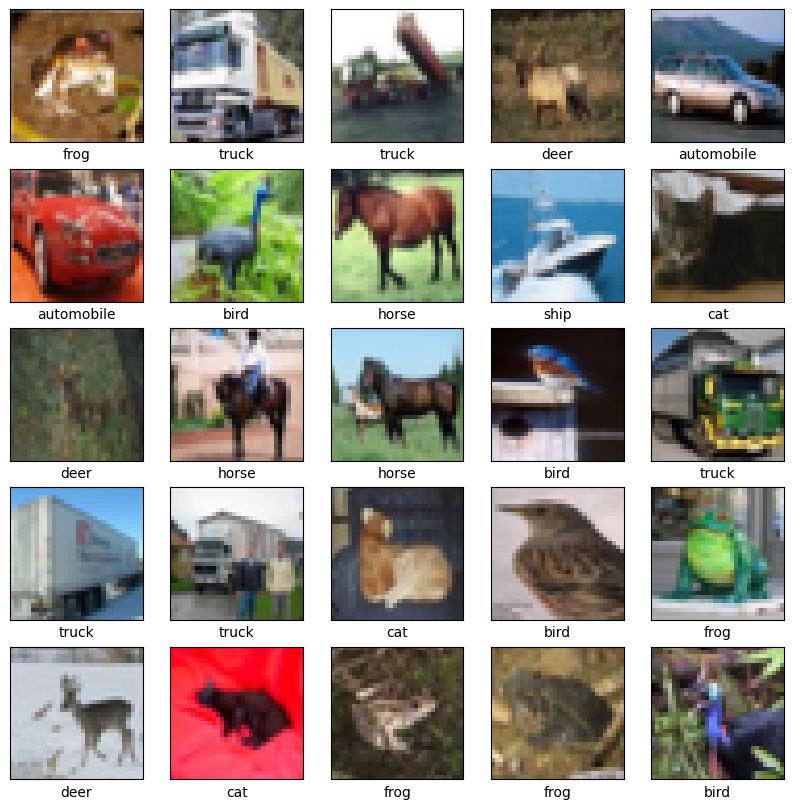

In [22]:
class_names = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
]

plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()

In [30]:
# Plot model performance
def plot_history(history):
    train_loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    train_acc = history.history["acc"]
    val_acc = history.history["val_acc"]

    plt.figure(figsize=(10, 10))

    plt.subplot(121)
    plt.plot(np.arange(1, len(train_loss) + 1), train_loss)
    plt.plot(np.arange(1, len(train_loss) + 1), val_loss)
    plt.legend(["train", "validation"])
    plt.grid()
    plt.xlabel("epoch")
    plt.ylabel("loss")

    plt.subplot(122)
    plt.plot(np.arange(1, len(train_loss) + 1), train_acc)
    plt.plot(np.arange(1, len(train_loss) + 1), val_acc)
    plt.legend(["train", "validation"])
    plt.grid()
    plt.xlabel("epoch")
    plt.ylabel("accuracy")

#### DenseBlock

([For each layer]:) BatchNormalization → ReLU → 1x1 Conv2D → BatchNormalization → ReLU → 3x3 Conv2D → Concatenate


In [96]:
# Define custom DenseBlock without bottleneck layer
class DenseBlock(tf.keras.layers.Layer):
    def __init__(self, num_layers, growth_rate):
        super(DenseBlock, self).__init__()

        self.num_layers = num_layers
        self.growth_rate = growth_rate
        
        self.layers_list = []
        for _ in range(num_layers):
            # Create a layer composition function
            layer_composition = [
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.ReLU(),
                tf.keras.layers.Conv2D(growth_rate, kernel_size=(3, 3), 
                                        padding='same', kernel_initializer='he_uniform')
            ]
            self.layers_list.append(layer_composition)
        
        self.concat_layer = tf.keras.layers.Concatenate()

    def call(self, x):
        inputs = [x]  # store the inputs

        for i in range(self.num_layers):
            batch_norm, relu, conv = self.layers_list[i] # get current layer composition
            
            y = batch_norm(x)
            y = relu(y)
            y = conv(y)
            
            # Add to inputs list
            inputs.append(y)
            
            # DenseNet feature reuse
            x = self.concat_layer(inputs)

        return x

#### TransitionLayer

BatchNormalization → ReLU → 1x1 Conv2D → AveragePooling2D


In [97]:
# Transition Layer
class TransitionLayer(tf.keras.layers.Layer):
    def __init__(self, compression_factor):
        super(TransitionLayer, self).__init__()

        self.compression_factor = compression_factor  # compression_factor factor
        
        self.batch_norm = tf.keras.layers.BatchNormalization()
        self.relu = tf.keras.layers.ReLU()
        self.avg_pool = tf.keras.layers.AveragePooling2D(pool_size=(2, 2), strides=2)

    def build(self, input_shape):
        channels = int(self.compression_factor * input_shape[-1])
        self.conv = tf.keras.layers.Conv2D(channels, kernel_size=(1, 1), padding="same")
        super(TransitionLayer, self).build(input_shape)

    def call(self, x):
        x = self.batch_norm(x)
        x = self.relu(x)
        x = self.conv(x) 
        out = self.avg_pool(x)
        return out

## Baseline Model


In [ ]:
# Define densenet model
GROWTH_RATE = 12
COMPRESSION_FACTOR = 0.2

# Define model architecture
in_layer = tf.keras.layers.Input(shape=(32, 32, 3))  # input layer
x = tf.keras.layers.Rescaling(1./255)(in_layer) # normalization layer
b = tf.keras.layers.Conv2D(64, kernel_size=(3, 3), padding="same")(x)

b = DenseBlock(4, GROWTH_RATE)(b)
b = DenseBlock(4, GROWTH_RATE)(b)

b = TransitionLayer(compression_factor=COMPRESSION_FACTOR)(b)

b = DenseBlock(8, GROWTH_RATE)(b)
b = DenseBlock(8, GROWTH_RATE)(b)

b = tf.keras.layers.GlobalAveragePooling2D()(b)  # Global Average Pooling
out_layer = tf.keras.layers.Dense(10, activation="softmax")(b)

# Build model
model = tf.keras.Model(inputs=in_layer, outputs=out_layer)

model.summary()

# Compile model 
model.compile(loss="sparse_categorical_crossentropy", optimizer='adam', metrics=['acc'])

Model: "functional_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_40 (InputLayer)     │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_7 (Rescaling)         │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_788 (Conv2D)             │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_block_84 (DenseBlock)     │ (None, 32, 32, 112)    │        36,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_block_85 (DenseBlock)     │ (None, 32, 32, 160)    │        58,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transition_layer_36             │ (None, 16, 16, 32)     │         5,792 │
│ (TransitionLayer)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_block_86 (DenseBlock)     │ (None, 16, 16, 128)    │        66,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_block_87 (DenseBlock)     │ (None, 16, 16, 224)    │       152,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_16     │ (None, 224)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 10)             │         2,250 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 323,722 (1.23 MB)

 Trainable params: 317,802 (1.21 MB)

 Non-trainable params: 5,920 (23.12 KB)

In [99]:
# Train model
history = model.fit(train_images, train_labels, epochs=50, batch_size=64, validation_split=0.1, 
                   callbacks=tf.keras.callbacks.EarlyStopping(patience=5))

Epoch 1/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 583s 818ms/step - acc: 0.3660 - loss: 1.7451 - val_acc: 0.4402 - val_loss: 1.4760
Epoch 2/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 567s 805ms/step - acc: 0.5868 - loss: 1.1331 - val_acc: 0.4546 - val_loss: 1.6786
Epoch 3/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 563s 799ms/step - acc: 0.6502 - loss: 0.9698 - val_acc: 0.6536 - val_loss: 1.0135
Epoch 4/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 544s 773ms/step - acc: 0.6901 - loss: 0.8642 - val_acc: 0.6008 - val_loss: 1.1414
Epoch 5/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 530s 753ms/step - acc: 0.7245 - loss: 0.7810 - val_acc: 0.5470 - val_loss: 1.5413
Epoch 6/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 531s 754ms/step - acc: 0.7491 - loss: 0.7079 - val_acc: 0.6606 - val_loss: 0.9923
Epoch 7/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 533s 757ms/step - acc: 0.7730 - loss: 0.6501 - val_acc: 0.5878 - val_loss: 1.3899
Epoch 8/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 530s 752ms/step - acc: 0.7963 - loss: 0.5842 - val_acc: 0.7090 - val_loss: 0.9225
Epoch 9/50
704/704 ━━━━━

In [ ]:
plot_history(history)

In [ ]:
test_loss, test_acc = model.evaluate(test_images, test_labels)

## More Transition Layers


In [75]:
# Define densenet model
GROWTH_RATE = 12
COMPRESSION_FACTOR = 0.5

# Define model architecture
in_layer = tf.keras.layers.Input(shape=(32, 32, 3))  # input layer
x = tf.keras.layers.Rescaling(1./255)(in_layer) # normalization layer
b = tf.keras.layers.Conv2D(64, kernel_size=(3, 3), padding="same")(x)

b = DenseBlock(4, GROWTH_RATE)(b)
b = TransitionLayer(compression_factor=COMPRESSION_FACTOR)(b)

b = DenseBlock(4, GROWTH_RATE)(b)
b = TransitionLayer(compression_factor=COMPRESSION_FACTOR)(b)

b = DenseBlock(8, GROWTH_RATE)(b)
b = TransitionLayer(compression_factor=COMPRESSION_FACTOR)(b)

b = tf.keras.layers.GlobalAveragePooling2D()(b)  # Global Average Pooling
out_layer = tf.keras.layers.Dense(10, activation="softmax")(b)

# Build model
model = tf.keras.Model(inputs=in_layer, outputs=out_layer)
    

model.summary()

# Compile model 
model.compile(loss="sparse_categorical_crossentropy", optimizer='adam', metrics=['acc'])

Model: "functional_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_29 (InputLayer)     │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_535 (Conv2D)             │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_block_63 (DenseBlock)     │ (None, 32, 32, 112)    │        36,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transition_layer_16             │ (None, 16, 16, 56)     │         6,776 │
│ (TransitionLayer)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_block_64 (DenseBlock)     │ (None, 16, 16, 104)    │        33,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transition_layer_17             │ (None, 8, 8, 52)       │         5,876 │
│ (TransitionLayer)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_block_65 (DenseBlock)     │ (None, 8, 8, 148)      │        84,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transition_layer_18             │ (None, 4, 4, 74)       │        11,618 │
│ (TransitionLayer)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_10     │ (None, 74)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 10)             │           750 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 181,116 (707.48 KB)

 Trainable params: 177,636 (693.89 KB)

 Non-trainable params: 3,480 (13.59 KB)

In [76]:
# Train model
history = model.fit(train_images, train_labels, epochs=50, batch_size=64, validation_split=0.1, 
                   callbacks=tf.keras.callbacks.EarlyStopping(patience=5))

Epoch 1/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 251s 349ms/step - acc: 0.4073 - loss: 1.5962 - val_acc: 0.5072 - val_loss: 1.4038
Epoch 2/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 238s 338ms/step - acc: 0.6216 - loss: 1.0574 - val_acc: 0.5882 - val_loss: 1.2096
Epoch 3/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 241s 343ms/step - acc: 0.6909 - loss: 0.8643 - val_acc: 0.6010 - val_loss: 1.0836
Epoch 4/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 241s 342ms/step - acc: 0.7337 - loss: 0.7534 - val_acc: 0.5786 - val_loss: 1.2432
Epoch 5/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 241s 342ms/step - acc: 0.7655 - loss: 0.6611 - val_acc: 0.7392 - val_loss: 0.7574
Epoch 6/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 241s 343ms/step - acc: 0.7995 - loss: 0.5720 - val_acc: 0.7026 - val_loss: 0.9697
Epoch 7/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 243s 345ms/step - acc: 0.8174 - loss: 0.5167 - val_acc: 0.6934 - val_loss: 0.9413
Epoch 8/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 241s 342ms/step - acc: 0.8340 - loss: 0.4761 - val_acc: 0.7060 - val_loss: 0.9499
Epoch 9/50
704/704 ━━━━━

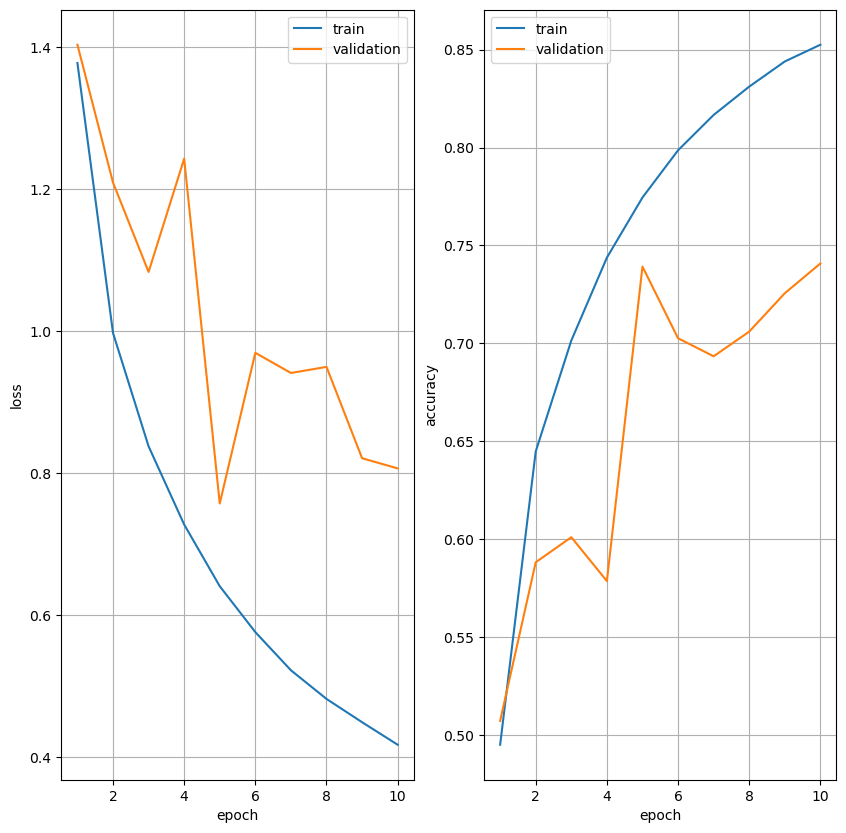

In [77]:
plot_history(history)


In [ ]:
test_loss, test_acc = model.evaluate(test_images, test_labels)

## Model with Data Augementation


In [78]:
GROWTH_RATE = 12
COMPRESSION_FACTOR = 0.5

data_augmentation = tf.keras.Sequential([
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    ])

# Define model architecture
in_layer = tf.keras.layers.Input(shape=(32, 32, 3))  # input layer
x = tf.keras.layers.Rescaling(1./255)(in_layer) # normalization layer

x = data_augmentation(x) # data augmentation

b = tf.keras.layers.Conv2D(64, kernel_size=(3, 3), padding="same")(x)

b = DenseBlock(4, GROWTH_RATE)(b)
b = TransitionLayer(compression_factor=COMPRESSION_FACTOR)(b)

b = DenseBlock(4, GROWTH_RATE)(b)
b = TransitionLayer(compression_factor=COMPRESSION_FACTOR)(b)

b = DenseBlock(8, GROWTH_RATE)(b)
b = TransitionLayer(compression_factor=COMPRESSION_FACTOR)(b)

b = tf.keras.layers.GlobalAveragePooling2D()(b)  # Global Average Pooling
out_layer = tf.keras.layers.Dense(10, activation="softmax")(b)

# Build model
model = tf.keras.Model(inputs=in_layer, outputs=out_layer)

model.summary()

# Compile model 
model.compile(loss="sparse_categorical_crossentropy", optimizer='adam', metrics=['acc'])

Model: "functional_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_30 (InputLayer)     │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_24 (Sequential)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_555 (Conv2D)             │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_block_66 (DenseBlock)     │ (None, 32, 32, 112)    │        36,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transition_layer_19             │ (None, 16, 16, 56)     │         6,776 │
│ (TransitionLayer)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_block_67 (DenseBlock)     │ (None, 16, 16, 104)    │        33,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transition_layer_20             │ (None, 8, 8, 52)       │         5,876 │
│ (TransitionLayer)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_block_68 (DenseBlock)     │ (None, 8, 8, 148)      │        84,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transition_layer_21             │ (None, 4, 4, 74)       │        11,618 │
│ (TransitionLayer)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_11     │ (None, 74)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 10)             │           750 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 181,116 (707.48 KB)

 Trainable params: 177,636 (693.89 KB)

 Non-trainable params: 3,480 (13.59 KB)

In [79]:
# Train model
history = model.fit(train_images, train_labels, epochs=50, batch_size=64, validation_split=0.1, 
                   callbacks=tf.keras.callbacks.EarlyStopping(patience=5))

Epoch 1/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 246s 343ms/step - acc: 0.3866 - loss: 1.6598 - val_acc: 0.3382 - val_loss: 2.7393
Epoch 2/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 239s 339ms/step - acc: 0.5953 - loss: 1.1236 - val_acc: 0.6148 - val_loss: 1.1500
Epoch 3/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 240s 341ms/step - acc: 0.6753 - loss: 0.9233 - val_acc: 0.5018 - val_loss: 1.5970
Epoch 4/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 242s 344ms/step - acc: 0.7202 - loss: 0.7918 - val_acc: 0.6476 - val_loss: 1.0898
Epoch 5/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 241s 342ms/step - acc: 0.7465 - loss: 0.7302 - val_acc: 0.7470 - val_loss: 0.7348
Epoch 6/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 241s 342ms/step - acc: 0.7714 - loss: 0.6569 - val_acc: 0.6834 - val_loss: 0.9670
Epoch 7/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 242s 344ms/step - acc: 0.7831 - loss: 0.6219 - val_acc: 0.7518 - val_loss: 0.7611
Epoch 8/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 240s 341ms/step - acc: 0.7976 - loss: 0.5777 - val_acc: 0.7372 - val_loss: 0.8223
Epoch 9/50
704/704 ━━━━━

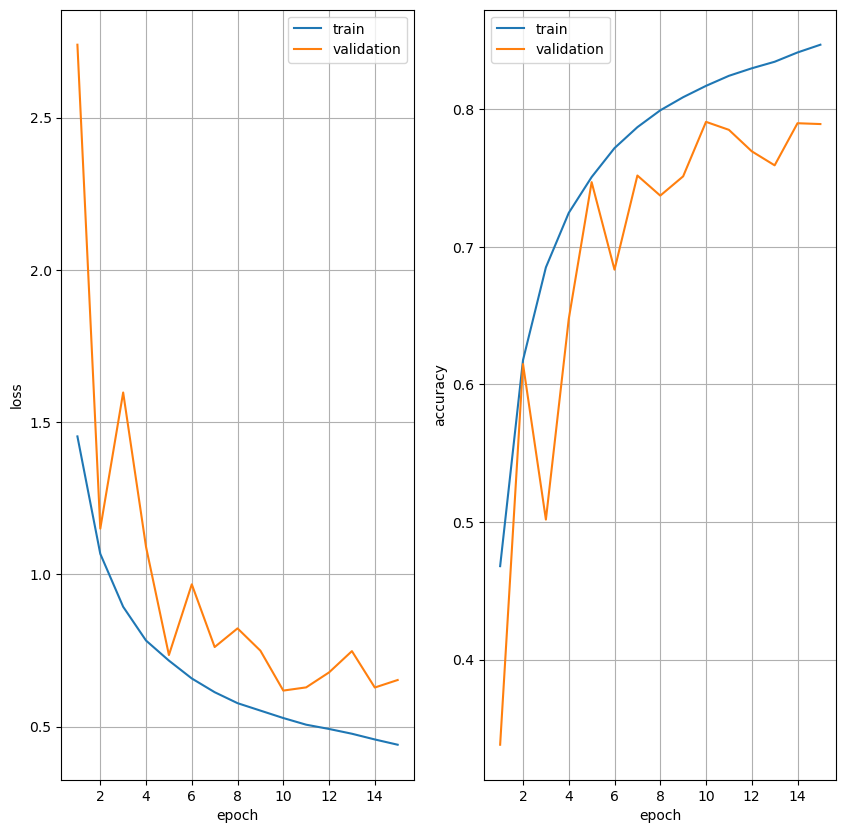

In [80]:
plot_history(history)

In [81]:
test_loss, test_acc = model.evaluate(test_images, test_labels)

313/313 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - acc: 0.7835 - loss: 0.6861


## Model with more layers per block


In [82]:
GROWTH_RATE = 12
COMPRESSION_FACTOR = 0.5

data_augmentation = tf.keras.Sequential([
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    ])

# Define model architecture
in_layer = tf.keras.layers.Input(shape=(32, 32, 3))  # input layer
x = tf.keras.layers.Rescaling(1./255)(in_layer) # normalization layer

x = data_augmentation(x) # data augmentation

b = tf.keras.layers.Conv2D(64, kernel_size=(3, 3), padding="same")(x)

b = DenseBlock(6, GROWTH_RATE)(b)
b = TransitionLayer(compression_factor=COMPRESSION_FACTOR)(b)

b = DenseBlock(12, GROWTH_RATE)(b)
b = TransitionLayer(compression_factor=COMPRESSION_FACTOR)(b)

b = DenseBlock(24, GROWTH_RATE)(b)
b = TransitionLayer(compression_factor=COMPRESSION_FACTOR)(b)

b = tf.keras.layers.GlobalAveragePooling2D()(b)  # Global Average Pooling
out_layer = tf.keras.layers.Dense(10, activation="softmax")(b)

# Build model
model = tf.keras.Model(inputs=in_layer, outputs=out_layer)

model.summary()

# Compile model 
model.compile(loss="sparse_categorical_crossentropy", optimizer='adam', metrics=['acc'])

Model: "functional_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_32 (InputLayer)     │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_2 (Rescaling)         │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_25 (Sequential)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_575 (Conv2D)             │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_block_69 (DenseBlock)     │ (None, 32, 32, 136)    │        63,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transition_layer_22             │ (None, 16, 16, 68)     │         9,860 │
│ (TransitionLayer)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_block_70 (DenseBlock)     │ (None, 16, 16, 212)    │       180,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transition_layer_23             │ (None, 8, 8, 106)      │        23,426 │
│ (TransitionLayer)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_block_71 (DenseBlock)     │ (None, 8, 8, 394)      │       656,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transition_layer_24             │ (None, 4, 4, 197)      │        79,391 │
│ (TransitionLayer)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_12     │ (None, 197)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 10)             │         1,980 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,016,089 (3.88 MB)

 Trainable params: 998,549 (3.81 MB)

 Non-trainable params: 17,540 (68.52 KB)

In [83]:
# Train model
history = model.fit(train_images, train_labels, epochs=50, batch_size=64, validation_split=0.1, 
                   callbacks=tf.keras.callbacks.EarlyStopping(patience=5))

Epoch 1/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 675s 941ms/step - acc: 0.3954 - loss: 1.6601 - val_acc: 0.4732 - val_loss: 1.4343
Epoch 2/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 656s 932ms/step - acc: 0.6270 - loss: 1.0401 - val_acc: 0.6084 - val_loss: 1.1599
Epoch 3/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 656s 932ms/step - acc: 0.7051 - loss: 0.8235 - val_acc: 0.4688 - val_loss: 2.4443
Epoch 4/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 662s 941ms/step - acc: 0.7547 - loss: 0.6982 - val_acc: 0.7044 - val_loss: 0.9235
Epoch 5/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 659s 936ms/step - acc: 0.7829 - loss: 0.6230 - val_acc: 0.6926 - val_loss: 0.9840
Epoch 6/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 669s 950ms/step - acc: 0.8055 - loss: 0.5635 - val_acc: 0.7768 - val_loss: 0.6498
Epoch 7/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 668s 949ms/step - acc: 0.8232 - loss: 0.5133 - val_acc: 0.7246 - val_loss: 0.8541
Epoch 8/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 659s 936ms/step - acc: 0.8421 - loss: 0.4623 - val_acc: 0.7982 - val_loss: 0.6253
Epoch 9/50
704/704 ━━━━━

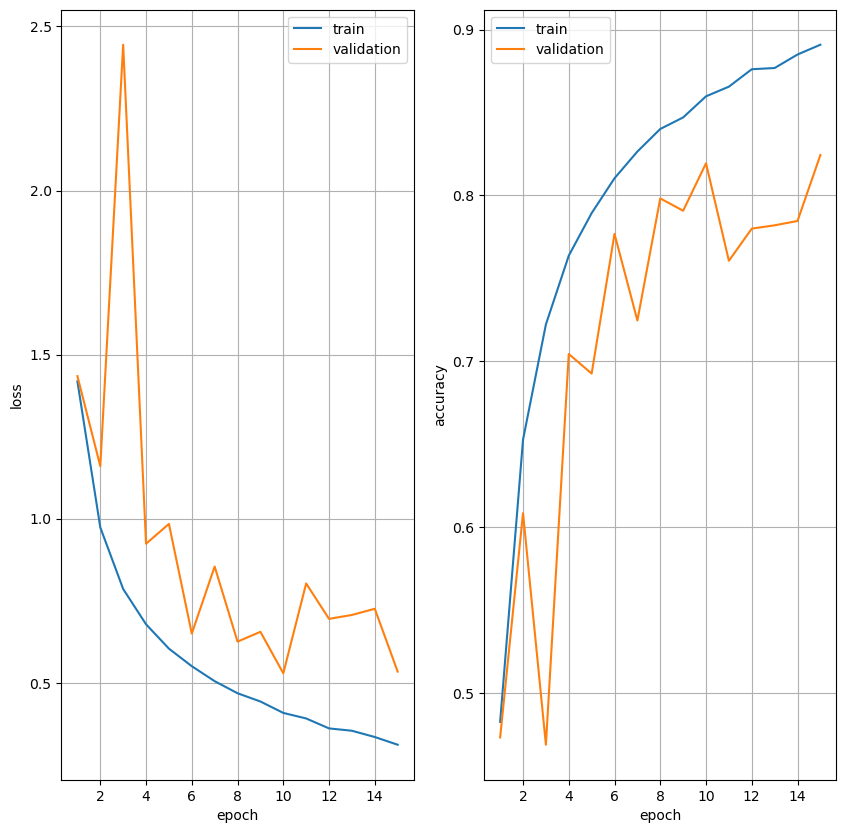

In [84]:
plot_history(history)


In [85]:
test_loss, test_acc = model.evaluate(test_images, test_labels)

313/313 ━━━━━━━━━━━━━━━━━━━━ 43s 138ms/step - acc: 0.8176 - loss: 0.5489


#### with Bottleneck layer


## Using Dropout


In [ ]:
GROWTH_RATE = 12
COMPRESSION_FACTOR = 0.5
DROPOUT_RATE = 0.2

data_augmentation = tf.keras.Sequential([
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    ])

# Define model architecture
in_layer = tf.keras.layers.Input(shape=(32, 32, 3))  # input layer
x = tf.keras.layers.Rescaling(1./255)(in_layer) # normalization layer

b = tf.keras.layers.Conv2D(64, kernel_size=(3, 3), padding="same")(x)

b = DenseBlock(4, GROWTH_RATE)(b)
b = tf.keras.layers.Dropout(DROPOUT_RATE)(b)
b = TransitionLayer(compression_factor=COMPRESSION_FACTOR)(b)

b = DenseBlock(4, GROWTH_RATE)(b)
b = tf.keras.layers.Dropout(DROPOUT_RATE)(b)
b = TransitionLayer(compression_factor=COMPRESSION_FACTOR)(b)

b = DenseBlock(8, GROWTH_RATE)(b)
b = tf.keras.layers.Dropout(DROPOUT_RATE)(b)
b = TransitionLayer(compression_factor=COMPRESSION_FACTOR)(b)

b = tf.keras.layers.GlobalAveragePooling2D()(b)  # Global Average Pooling
out_layer = tf.keras.layers.Dense(10, activation="softmax")(b)

# Build model
model = tf.keras.Model(inputs=in_layer, outputs=out_layer)

model.summary()

# Compile model 
model.compile(loss="sparse_categorical_crossentropy", optimizer='adam', metrics=['acc'])

Model: "functional_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_35 (InputLayer)     │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_4 (Rescaling)         │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_626 (Conv2D)             │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_block_73 (DenseBlock)     │ (None, 32, 32, 112)    │        36,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 32, 112)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transition_layer_25             │ (None, 16, 16, 56)     │         6,776 │
│ (TransitionLayer)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_block_74 (DenseBlock)     │ (None, 16, 16, 104)    │        33,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16, 16, 104)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transition_layer_26             │ (None, 8, 8, 52)       │         5,876 │
│ (TransitionLayer)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_block_75 (DenseBlock)     │ (None, 8, 8, 148)      │        84,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 8, 8, 148)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transition_layer_27             │ (None, 4, 4, 74)       │        11,618 │
│ (TransitionLayer)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_13     │ (None, 74)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 10)             │           750 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 181,116 (707.48 KB)

 Trainable params: 177,636 (693.89 KB)

 Non-trainable params: 3,480 (13.59 KB)

In [88]:
# Train model
history = model.fit(train_images, train_labels, epochs=50, batch_size=64, validation_split=0.1, 
                   callbacks=tf.keras.callbacks.EarlyStopping(patience=5))

Epoch 1/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 248s 345ms/step - acc: 0.3864 - loss: 1.6482 - val_acc: 0.3854 - val_loss: 1.8985
Epoch 2/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 233s 330ms/step - acc: 0.6072 - loss: 1.0931 - val_acc: 0.5720 - val_loss: 1.2614
Epoch 3/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 241s 342ms/step - acc: 0.6716 - loss: 0.9186 - val_acc: 0.6178 - val_loss: 1.1878
Epoch 4/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 235s 333ms/step - acc: 0.7083 - loss: 0.8181 - val_acc: 0.5670 - val_loss: 1.4242
Epoch 5/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 243s 345ms/step - acc: 0.7473 - loss: 0.7211 - val_acc: 0.6898 - val_loss: 0.9020
Epoch 6/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 237s 336ms/step - acc: 0.7685 - loss: 0.6598 - val_acc: 0.7304 - val_loss: 0.7809
Epoch 7/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 242s 344ms/step - acc: 0.7851 - loss: 0.6169 - val_acc: 0.5994 - val_loss: 1.4780
Epoch 8/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 231s 329ms/step - acc: 0.7982 - loss: 0.5714 - val_acc: 0.5810 - val_loss: 1.5672
Epoch 9/50
704/704 ━━━━━

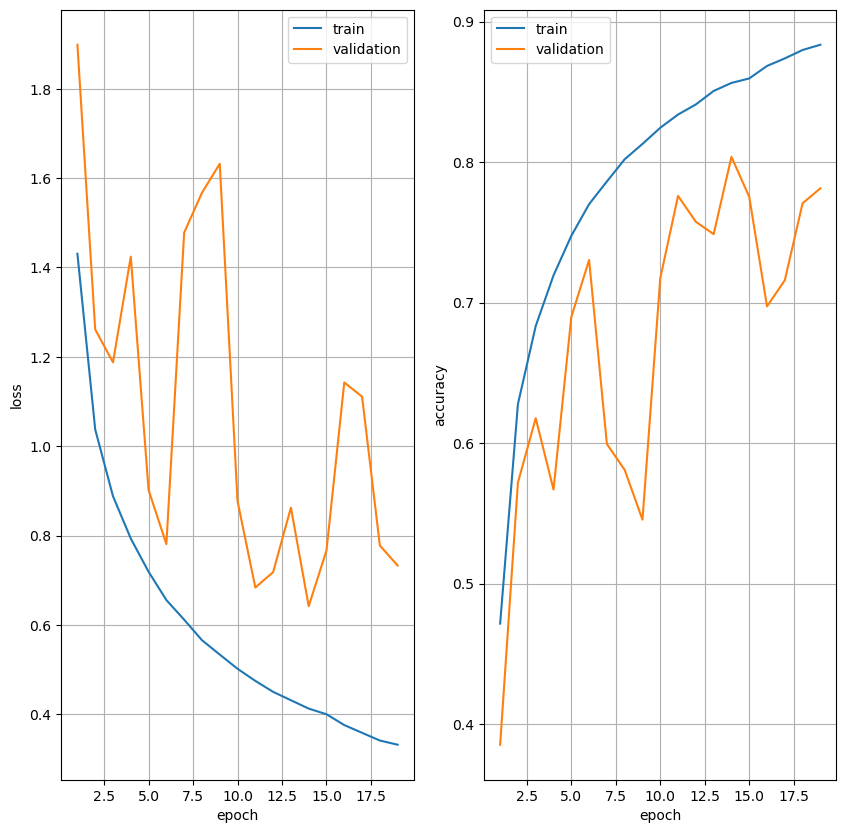

In [89]:
plot_history(history)


In [90]:
test_loss, test_acc = model.evaluate(test_images, test_labels)


313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - acc: 0.7797 - loss: 0.7372


# Contest Model


In [ ]:
GROWTH_RATE = 24
COMPRESSION_FACTOR = 0.5

data_augmentation = tf.keras.Sequential([
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    ])

# Define model architecture
in_layer = tf.keras.layers.Input(shape=(32, 32, 3))  # input layer
x = tf.keras.layers.Rescaling(1./255)(in_layer) # normalization layer

x = data_augmentation(x) # data augmentation

b = tf.keras.layers.Conv2D(64, kernel_size=(3, 3), padding="same")(x)

b = DenseBlock(6, GROWTH_RATE)(b)
b = TransitionLayer(compression_factor=COMPRESSION_FACTOR)(b)

b = DenseBlock(12, GROWTH_RATE)(b)
b = TransitionLayer(compression_factor=COMPRESSION_FACTOR)(b)

b = DenseBlock(24, GROWTH_RATE)(b)
b = TransitionLayer(compression_factor=COMPRESSION_FACTOR)(b)

b = DenseBlock(24, GROWTH_RATE)(b)
b = TransitionLayer(compression_factor=COMPRESSION_FACTOR)(b)

b = tf.keras.layers.GlobalAveragePooling2D()(b)  # Global Average Pooling
out_layer = tf.keras.layers.Dense(10, activation="softmax")(b)

# Build model
model = tf.keras.Model(inputs=in_layer, outputs=out_layer)

model.summary()

# Compile model 
model.compile(loss="sparse_categorical_crossentropy", optimizer='adam', metrics=['acc'])

Model: "functional_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_38 (InputLayer)     │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_6 (Rescaling)         │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_29 (Sequential)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_717 (Conv2D)             │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_block_80 (DenseBlock)     │ (None, 32, 32, 208)    │       163,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transition_layer_32             │ (None, 16, 16, 104)    │        22,568 │
│ (TransitionLayer)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_block_81 (DenseBlock)     │ (None, 16, 16, 392)    │       623,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transition_layer_33             │ (None, 8, 8, 196)      │        78,596 │
│ (TransitionLayer)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_block_82 (DenseBlock)     │ (None, 8, 8, 772)      │     2,492,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transition_layer_34             │ (None, 4, 4, 386)      │       301,466 │
│ (TransitionLayer)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_block_83 (DenseBlock)     │ (None, 4, 4, 962)      │     3,495,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transition_layer_35             │ (None, 2, 2, 481)      │       467,051 │
│ (TransitionLayer)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_15     │ (None, 481)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 10)             │         4,820 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,652,117 (29.19 MB)

 Trainable params: 7,585,865 (28.94 MB)

 Non-trainable params: 66,252 (258.80 KB)

In [92]:
# Train model
history = model.fit(train_images, train_labels, epochs=50, batch_size=32, validation_split=0.1, 
                   callbacks=tf.keras.callbacks.EarlyStopping(patience=5))

Epoch 1/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 1463s 1s/step - acc: 0.3380 - loss: 1.9083 - val_acc: 0.4262 - val_loss: 1.8026
Epoch 2/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 1447s 1s/step - acc: 0.5833 - loss: 1.1553 - val_acc: 0.6126 - val_loss: 1.1608
Epoch 3/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 1386s 985ms/step - acc: 0.6785 - loss: 0.9105 - val_acc: 0.7208 - val_loss: 0.7995
Epoch 4/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 1434s 1s/step - acc: 0.7457 - loss: 0.7349 - val_acc: 0.7810 - val_loss: 0.6568
Epoch 5/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 1360s 966ms/step - acc: 0.7886 - loss: 0.6162 - val_acc: 0.7722 - val_loss: 0.6800
Epoch 6/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 1296s 921ms/step - acc: 0.8120 - loss: 0.5489 - val_acc: 0.7986 - val_loss: 0.6209
Epoch 7/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 1325s 942ms/step - acc: 0.8367 - loss: 0.4726 - val_acc: 0.7486 - val_loss: 0.7744
Epoch 8/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 1342s 954ms/step - acc: 0.8521 - loss: 0.4281 - val_acc: 0.8180 - val_loss: 0.5455
Epoch 9/5

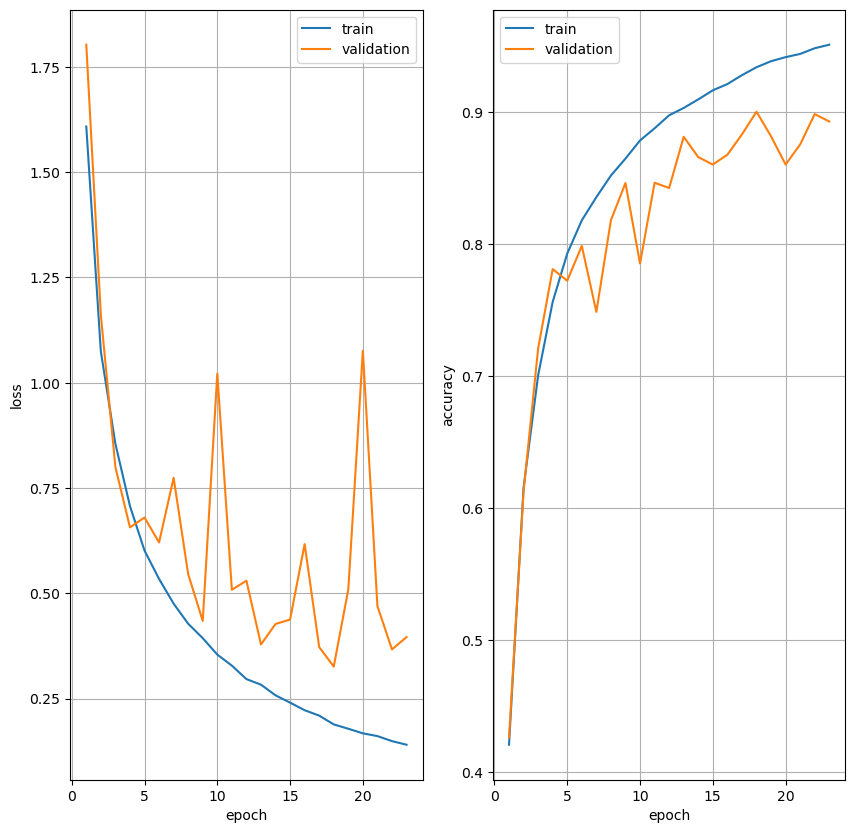

In [94]:
plot_history(history)

In [95]:
test_loss, test_acc = model.evaluate(test_images, test_labels)

313/313 ━━━━━━━━━━━━━━━━━━━━ 74s 231ms/step - acc: 0.1027 - loss: 2.3033


In [102]:
GROWTH_RATE = 12
COMPRESSION_FACTOR = 0.5
DROPOUT_RATE = 0.2

data_augmentation = tf.keras.Sequential([
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    ])

# Define model architecture
in_layer = tf.keras.layers.Input(shape=(32, 32, 3))  # input layer
x = tf.keras.layers.Rescaling(1./255)(in_layer) # normalization layer

x = data_augmentation(x) # data augmentation

b = tf.keras.layers.Conv2D(12, kernel_size=(3, 3), padding="same")(x)

b = DenseBlock(6, GROWTH_RATE)(b)
b = tf.keras.layers.Dropout(DROPOUT_RATE)(b)
b = TransitionLayer(compression_factor=COMPRESSION_FACTOR)(b)

b = DenseBlock(12, GROWTH_RATE)(b)
b = tf.keras.layers.Dropout(DROPOUT_RATE)(b)
b = TransitionLayer(compression_factor=COMPRESSION_FACTOR)(b)

b = DenseBlock(24, GROWTH_RATE)(b)
b = tf.keras.layers.Dropout(DROPOUT_RATE)(b)
b = TransitionLayer(compression_factor=COMPRESSION_FACTOR)(b)


b = tf.keras.layers.GlobalAveragePooling2D()(b)  # Global Average Pooling
out_layer = tf.keras.layers.Dense(10, activation="softmax")(b)

# Build model
model = tf.keras.Model(inputs=in_layer, outputs=out_layer)

model.summary()

# Compile model 
model.compile(loss="sparse_categorical_crossentropy", optimizer='adam', metrics=['acc'])

Model: "functional_32"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_43 (InputLayer)     │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_9 (Rescaling)         │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_31 (Sequential)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_860 (Conv2D)             │ (None, 32, 32, 12)     │           336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_block_91 (DenseBlock)     │ (None, 32, 32, 84)     │        28,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 32, 32, 84)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transition_layer_40             │ (None, 16, 16, 42)     │         3,906 │
│ (TransitionLayer)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_block_92 (DenseBlock)     │ (None, 16, 16, 186)    │       145,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 16, 16, 186)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transition_layer_41             │ (None, 8, 8, 93)       │        18,135 │
│ (TransitionLayer)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_block_93 (DenseBlock)     │ (None, 8, 8, 381)      │       621,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 8, 8, 381)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transition_layer_42             │ (None, 4, 4, 190)      │        74,104 │
│ (TransitionLayer)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_18     │ (None, 190)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 10)             │         1,910 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 893,199 (3.41 MB)

 Trainable params: 877,713 (3.35 MB)

 Non-trainable params: 15,486 (60.49 KB)

In [103]:
# Train model
history = model.fit(train_images, train_labels, epochs=50, batch_size=64, validation_split=0.1, 
                   callbacks=tf.keras.callbacks.EarlyStopping(patience=5))

Epoch 1/50
  7/704 ━━━━━━━━━━━━━━━━━━━━ 7:57 684ms/step - acc: 0.1353 - loss: 2.4004

KeyboardInterrupt: 